# Modelo CVRP

In [5]:
import pandas as pd
!python -m pip install -i https://pypi.gurobi.com gurobipy
!pip install haversine
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Formulación e Implementación

In [6]:
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from haversine import haversine
from gurobipy import*
import pandas as pd
import numpy as np

"""
Se prueba el modelo del CVRP modelado con restricciones indicadoras con 
solamente 20 fincas, con el fin de verificar cuál sería el comportamiento 
de los camiones en la flota con la producción que se está manejando.
"""

# Conjuntos
n = 20
N = [i for i in range(1, n)] # Número de clientes
V = [0] + N # Número de nodos en la red (incluyendo el centro post cosecha)
A = [(i, j) for i in V for j in V if i != j] # Arcos en la red

# Parámetros
# Matriz de distancia:
lats = list(coord_df['Latitud'])
longs = list(coord_df['Longitud'])
ubFincas = []
for i in range(n):
  ubFincas.append((lats[i], longs[i]))
d = {(i, j):float(haversine(ubFincas[i], ubFincas[j])) for (i, j) in A}
# Producción de las fincas
p = list(produccion['Producción'][:n]) 
# Capacidad de los camiones 
Q = 250
# Número de vehículos
#K = round(sum(p)/Q)
K = 12

# Crear el modelo
modeloRuteo = Model('CVRP')
#modeloRuteo.setParam("OutputFlag",0)

# Variables de decisión
x = modeloRuteo.addVars(A, vtype=GRB.BINARY, name = 'x') # Si el arco (i, j) debe tomar valor
u = modeloRuteo.addVars(N, vtype=GRB.CONTINUOUS, name = 'u') # Variable continua para eliminar los subtours

# Restricciones
# Sólo puede existir un arco entrante hacia cada una de las fincas
modeloRuteo.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
# Sólo puede existir un arco saliente desde cada una de las fincas
modeloRuteo.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
# Sólo puede salir un número de vehículos K de la planta post cosecha
modeloRuteo.addConstr(quicksum(x[0, j] for j in N) == K)
# Sólo puede llegar un número de vehículos K hacia la planta post cosecha
modeloRuteo.addConstr(quicksum(x[i, 0] for i in N) == K)
# Eliminar soubtours
modeloRuteo.addConstrs((x[i, j] == 1) >> (u[i] + p[j] == u[j]) for (i, j) in A if i != 0 and j != 0)
# Límites de las variables u
modeloRuteo.addConstrs(u[i] >= p[i] for i in N)
modeloRuteo.addConstrs(u[i] <= Q for i in N)

# Función Objetivo
modeloRuteo.modelSense = GRB.MINIMIZE
modeloRuteo.setObjective(quicksum(x[i, j]*d[i, j] for (i, j) in A))

modeloRuteo.Params.MIPGap = 0.1
modeloRuteo.Params.TimeLimit = 60  # seconds
modeloRuteo.optimize()
#modeloRuteo.computeIIS()
#modeloRuteo.write("model.ilp")


Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 78 rows, 399 columns and 798 nonzeros
Model fingerprint: 0xb8a4375a
Model has 342 general constraints
Variable types: 19 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [1e+00, 9e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 304 rows and 0 columns
Presolve time: 0.05s
Presolved: 382 rows, 399 columns, 2128 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)
Found heuristic solution: objective 591.1124396
Found heuristic solution: objective 461.9000727

Root relaxation: objective 2.733349e+02, 27 iterat

## Resultados

Función objetivo:
302.74152


Rutas generadas (12 rutas):
[(0, 1), (1, 0)]
[(0, 3), (3, 0)]
[(0, 4), (4, 0)]
[(0, 5), (5, 0)]
[(0, 6), (6, 2), (2, 19), (19, 9), (9, 0)]
[(0, 7), (7, 0)]
[(0, 8), (8, 0)]
[(0, 10), (10, 0)]
[(0, 11), (11, 0)]
[(0, 12), (12, 0)]
[(0, 13), (13, 0)]
[(0, 17), (17, 16), (16, 18), (18, 15), (15, 14), (14, 0)]




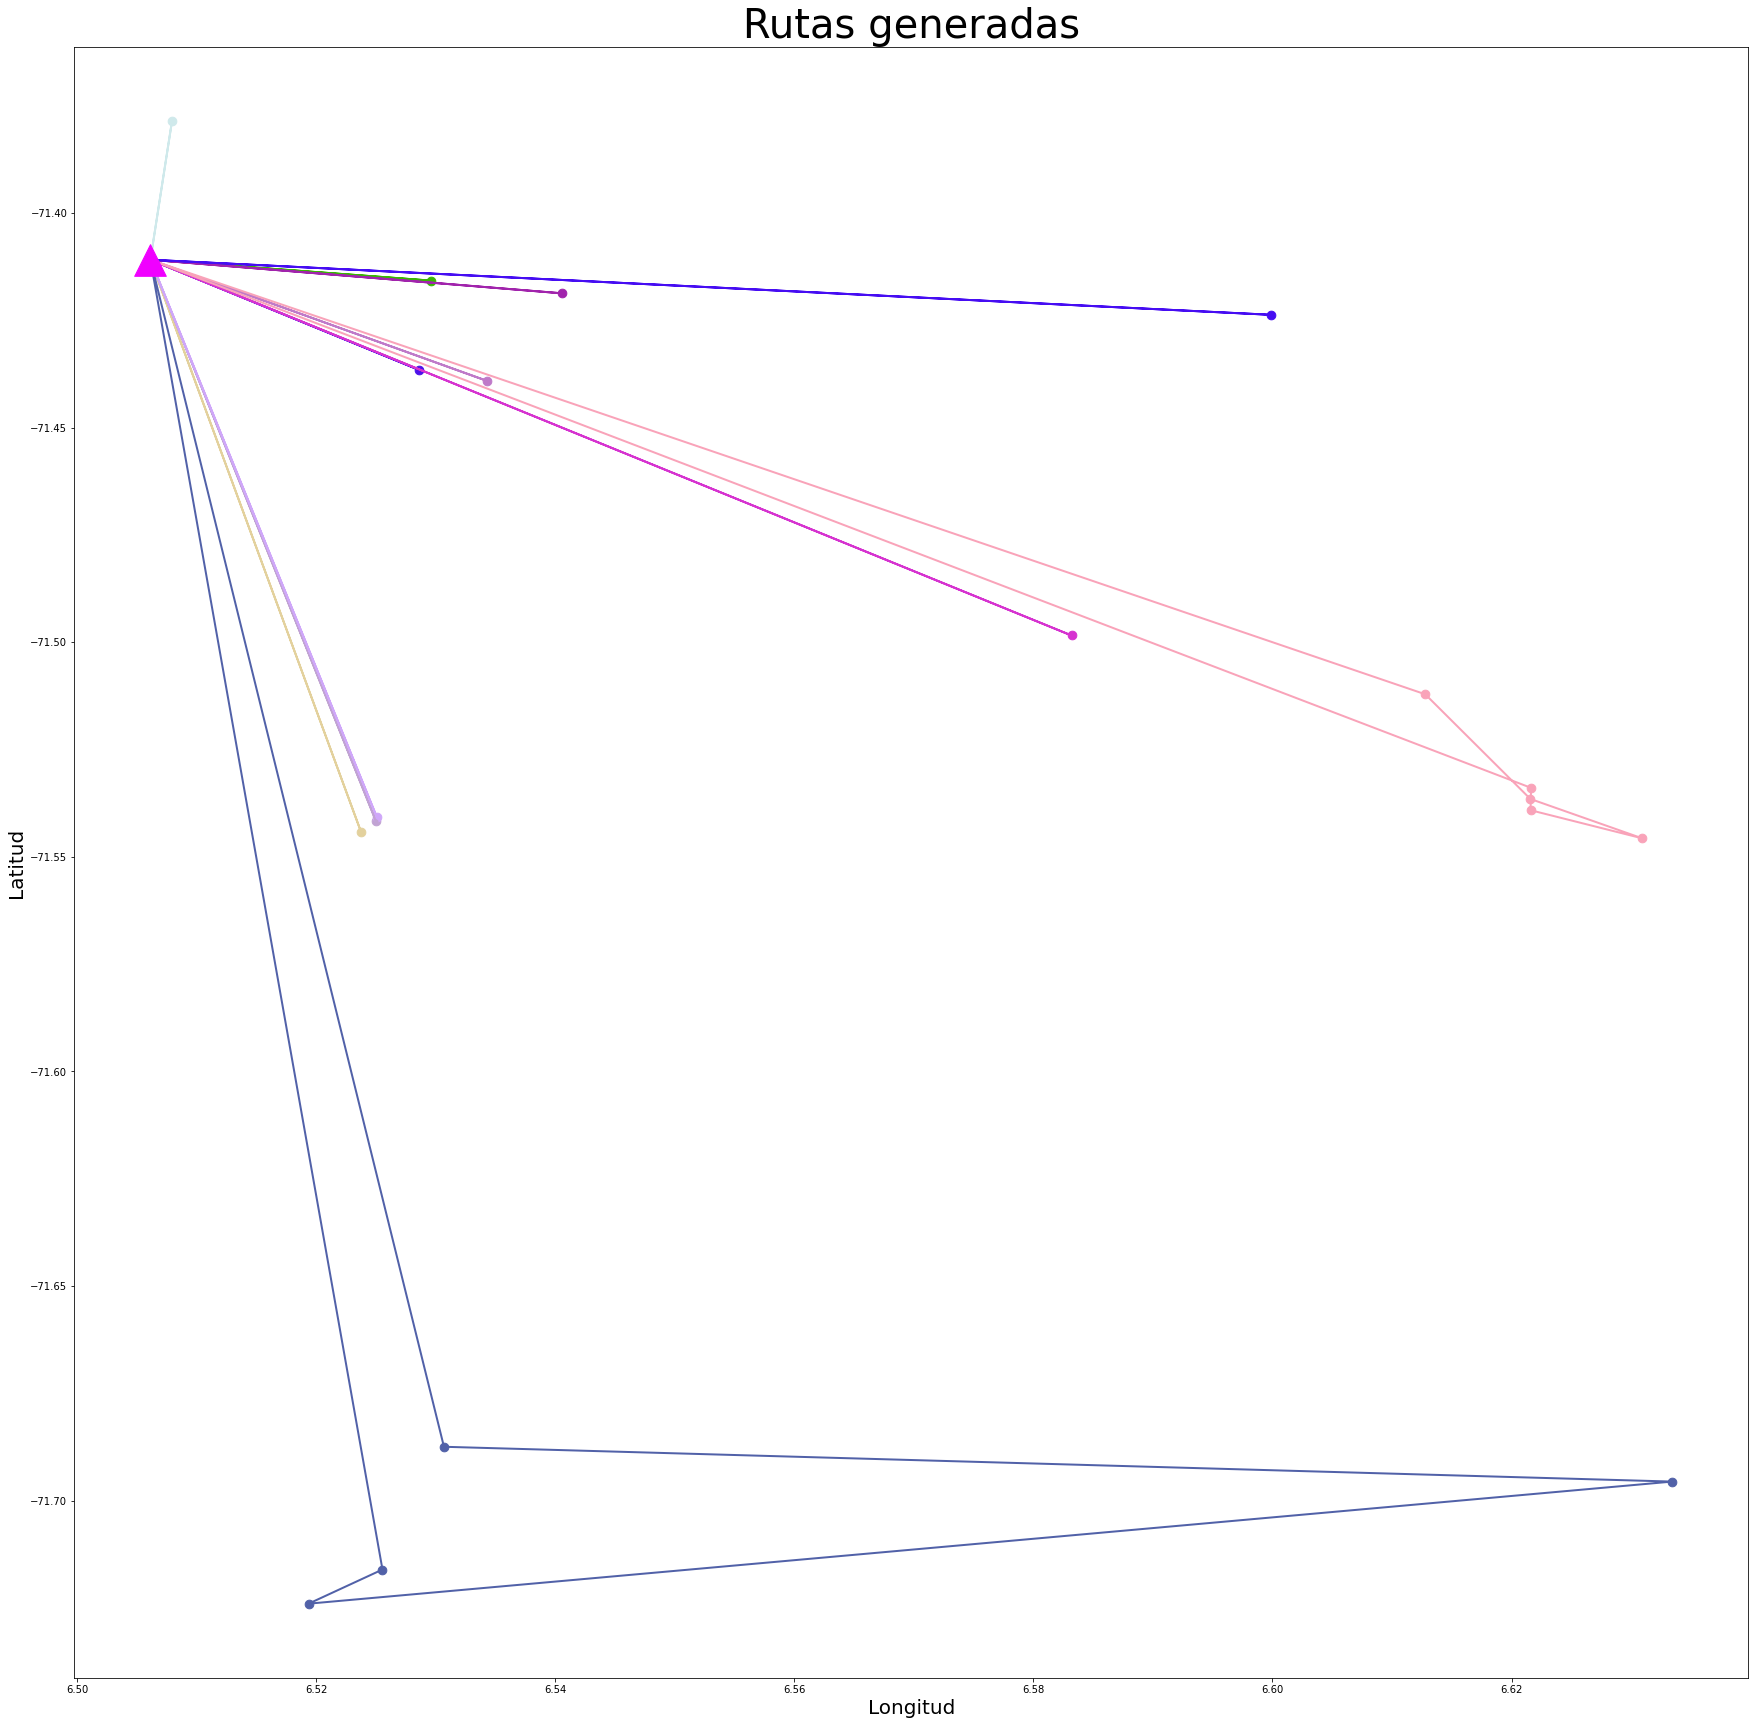

In [7]:
import matplotlib.pyplot as plt
import random

# Valor de la función objetivo
print('Función objetivo:')
print(round(modeloRuteo.getObjective().getValue(), 5))
print('\n')

# Rutas creadas
arcosSolu = [(i, j) for (i, j) in A if x[i, j].x == 1]
inicios = [arko for arko in arcosSolu if arko[0]== 0]
rutas = []
for arkoIni in inicios:
  rAct = []
  rAct.append(arkoIni)
  nodoAct = arkoIni[1]
  posi = 0
  while nodoAct != 0:
    arkoAct = arcosSolu[posi]
    if nodoAct == arkoAct[0]:
      rAct.append(arkoAct)
      nodoAct = arkoAct[1]
      posi = 0
    else:
      posi += 1
  rutas.append(rAct)
print(f'Rutas generadas ({len(rutas)} rutas):')
for ruta in rutas:
  print(ruta)
print('\n')

# Graficar las rutas
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)
for rutaCreada in rutas:
  tuplaColor = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
  rutaCreada = [i[j] for i in rutaCreada for j in range(2)]
  rutaCreada = list(dict.fromkeys(rutaCreada)) + [0]
  nUbFincas = [ubFincas[j] for j in rutaCreada]
  plt.scatter([j[0] for j in nUbFincas], [j[1] for j in nUbFincas],
              color = tuplaColor, marker = ".", s = 300, zorder = 1)
  plt.plot([j[0] for j in nUbFincas], [j[1] for j in nUbFincas], 
           color = tuplaColor, marker = ".", linewidth=2, zorder = 1)
  plt.xlabel('Longitud', fontsize = 20)
  plt.ylabel('Latitud', fontsize = 20)
  plt.title('Rutas generadas', fontsize = 40)
tuplaColor = (240/255, 0/255, 255/255)
plt.scatter(ubFincas[0][0], ubFincas[0][1], color = tuplaColor, marker = "^", s = 1000, zorder = 2)
plt.show()
